# Testing this example with <a href="https://github.com/fastmachinelearning/hls4ml" class="external">HLS4ML</a>
##### Copyright 2020 The TensorFlow Authors. Notebook modified by <a href="https://github.com/ThGkasios" class="external">ThGkasios</a>
Contents (*clickable links work only in Jupyter*):
- <a href="#Setup">Setup</a>
- <a href="#Import-the-mini-Speech-Commands-Dataset">Import the Dataset</a>
- <a href="#Convert-waveforms-to-spectrograms">Convert waveforms to spectrograms</a>
- <a href="#Build-and-train-the-model">Build and train the model</a>
- <a href="#Processing-the-model-for-hls4ml">Processing the model for hls4ml</a>
- <a href="#HLS4ML-Configuration-&-Compilation">HLS4ML Configuration and Compilation</a>
- <a href="#Resulting-Statistics">Resulting Statistics</a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Source: Tensorflow Example
### Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic <a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">automatic speech recognition</a> (ASR) model for recognizing eight different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) (<a href="https://arxiv.org/abs/1804.03209" class="external">Warden, 2018</a>), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition <a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">systems</a> are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

In [2]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
import plotting
import numpy as np
import seaborn as sns # Data Visualization
import tensorflow as tf

import hls4ml
import math

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2022-10-03 14:13:15.875851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 14:13:18.145989: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 14:13:18.146023: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-03 14:13:18.376989: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 14:13:22.269566: W tensorflow/stream_executor/platform/defaul

## Import the mini Speech Commands Dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file('mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True, cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands.sort()
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/161fcca8_nohash_0.wav', shape=(), dtype=string)


2022-10-03 14:13:28.704782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-03 14:13:28.707913: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-03 14:13:28.707958: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (diplrig0-VirtualBox): /proc/driver/nvidia/version does not exist
2022-10-03 14:13:28.719977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [6]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Read the audio files and their labels
In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The mini Speech Commands dataset only contains mono recordings. 

In [7]:
test_file = tf.io.read_file('data/mini_speech_commands/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [8]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [9]:
def get_label(file_path):
  parts = tf.strings.split(input=file_path, sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

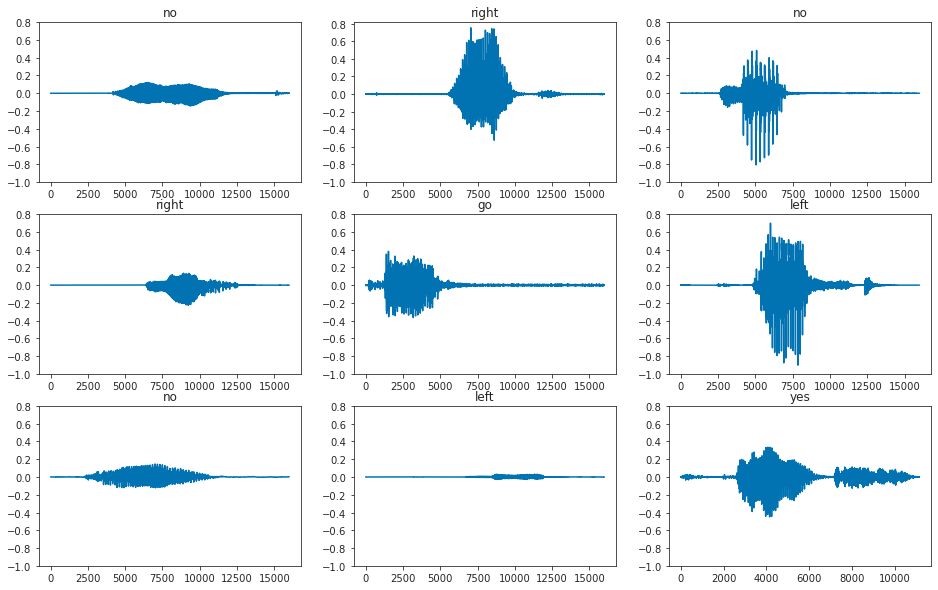

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  ax = axes[i // cols][i % cols]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1., 1., 0.2))
  ax.set_title(label.numpy().decode('utf-8'))

plt.show()

# Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [13]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  waveform = waveform[:16000]
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec, shading='nearest')

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

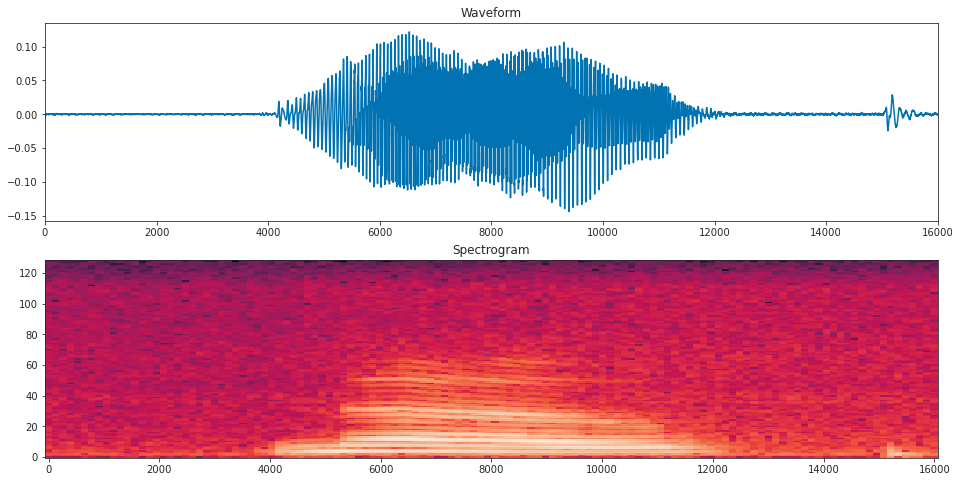

In [16]:
fig, axes = plt.subplots(2, figsize=(16, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [18]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

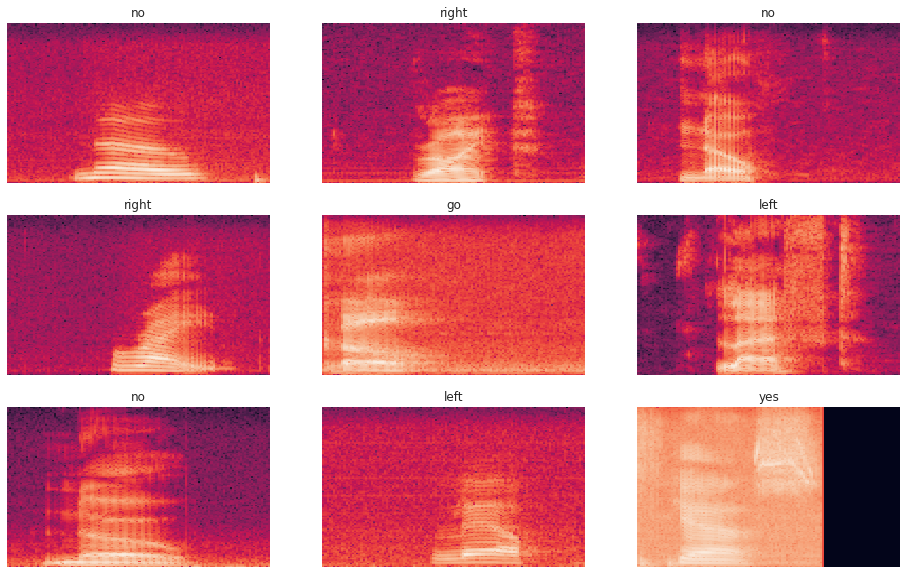

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  ax = axes[i // cols][i % cols]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [20]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(map_func=get_waveform_and_label,num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
  return output_ds

Batch the training and validation sets for model training, and add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [21]:
batch_size = 64
train_ds = spectrogram_ds.batch(batch_size).prefetch(AUTOTUNE)
val_ds = preprocess_dataset(val_files).batch(batch_size).prefetch(AUTOTUNE)

## Model Settings

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential" class="external">`tf.keras.Sequential`</a> model will use the following Keras preprocessing layers:
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing" class="external">`tf.keras.layers.Resizing`</a> downsamples the input to enable the model to train faster.
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization" class="external">`tf.keras.layers.Normalization`</a> normalizes each pixel in the image based on its mean and standard deviation.

**As of lately, hls4ml-0.5.x does not support these layers.** For the purposes of this implementation, `Resizing` is omitted, and `Normalization` is replaced by <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization" class="external">`tf.keras.layers.BatchNormalization`</a>, which is supported by hls4ml

In [22]:
input_shape = None
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


The parameters below accommodate different strategies for the design to be created by hls4ml
- The **fast** strategy can yield quick compilation time and quick results, but requires lowering the number of weights to about 1/60th of the original model, which significantly lowers the accuracy of the model, which limits its applicability and requires additional training to elevate accuracy above loss.
  - This is useful for first testing purposes
- The **slow** strategy achieves compiling the original model accurately, which means, but it takes a longer time to build the model using Vivado, and requires additional resources (such as more RAM on the computer)
  - This is the original model parameters
- The **experiment_base** strategy is the one design that worked fully. Make sure that the ReuseFactor for the `'dense'` layer is maximum in the hls4ml configuration by setting it as `model.get_layer(name='dense').weights[0].numpy().size`.
  - Without the maximum ReuseFactor, the design is too big for the FPGA resources.
  - The next steps from here are either:
    - Slowly lower the ReuseFactor as long as the design fits on the FPGA resources
    - Slowly make the number of parameters larger.
    

In [23]:
hw_strategies = {
    # Minimized Latency
    'fast' : {
        'conv2d' : 4,
        'conv2d_1' : 8,
        'dense' : 16,
        'Strategy' : 'Latency',
        'ReuseFactor' : 1,
        'UseMaxOnDense' : False,
        'epochs' : 10,
    },
    # Original model values
    'slow' : {
        'conv2d' : 32,
        'conv2d_1' : 64,
        'dense' : 128,
        'Strategy' : 'Resource',
        'ReuseFactor' : 9,
        'UseMaxOnDense' : False,
        'epochs' : 10,
    },
    'experiment_base' : {
        'conv2d' : 1,
        'conv2d_1' : None, #Not Used
        'dense' : 12,
        'Strategy' : 'Resource',
        'ReuseFactor' : 100,
        'UseMaxOnDense' : True,
        'epochs' : 100,
    },
    'experiment_max_bram' : {
        'conv2d' : 1,
        'conv2d_1' : None,
        'dense' : 40,
        'Strategy' : 'Resource',
        'ReuseFactor' : 100,
        'UseMaxOnDense' : True,
        'epochs' : 100,
    },
    'experiment_max_ff' : {
        'conv2d' : 1,
        'conv2d_1' : None,
        'dense' : 12,
        'Strategy' : 'Resource',
        'ReuseFactor' : [3,7,9,21,61,63,183,427,549,1281,3843,7686,11529,15372,23058,46116][-2],
        'UseMaxOnDense' : False,
        'epochs' : 100,
    },
}
hw_strat = 'experiment_max_ff'

Creating the `Sequential` model.

In [24]:
model = models.Sequential([])
model.add(layers.Input(shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(hw_strategies[hw_strat]['conv2d'], 3, activation='relu'))
if hw_strategies[hw_strat]['conv2d_1'] :
    model.add(layers.Conv2D(hw_strategies[hw_strat]['conv2d_1'], 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(hw_strategies[hw_strat]['dense'], activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 124, 129, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 122, 127, 1)       10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 63, 1)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 61, 63, 1)         0         
                                                                 
 flatten (Flatten)           (None, 3843)              0         
                                                                 
 dense (Dense)               (None, 12)                4

Configure the Keras model with the Adam optimizer and the cross-entropy loss:
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam" class="external">`tf.keras.optimizers.Adam`</a>: "Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments."
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy" class="external">`tf.keras.losses.SparseCategoricalCrossentropy`</a> works with labels being represented as integers of arbitrary value, instead of a "one-hot" representation.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=hw_strategies[hw_strat]['epochs'],
    callbacks=None, verbose=1
)

Epoch 1/100
100/100 [==============================] - 23s 213ms/step - loss: 2.0822 - accuracy: 0.1141 - val_loss: 2.0796 - val_accuracy: 0.1150
Epoch 2/100
100/100 [==============================] - 15s 153ms/step - loss: 2.0796 - accuracy: 0.1206 - val_loss: 2.0797 - val_accuracy: 0.1163
Epoch 3/100
100/100 [==============================] - 16s 161ms/step - loss: 2.0795 - accuracy: 0.1236 - val_loss: 2.0798 - val_accuracy: 0.1163
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 2.0794 - accuracy: 0.1239 - val_loss: 2.0800 - val_accuracy: 0.1150
Epoch 5/100
100/100 [==============================] - 17s 165ms/step - loss: 2.0796 - accuracy: 0.1245 - val_loss: 2.0800 - val_accuracy: 0.1163
Epoch 6/100
100/100 [==============================] - 17s 166ms/step - loss: 2.0792 - accuracy: 0.1239 - val_loss: 2.0801 - val_accuracy: 0.1163
Epoch 7/100
100/100 [==============================] - 17s 169ms/step - loss: 2.0793 - accuracy: 0.1236 - val_loss: 2.0801 -

Let's plot the training and validation loss curves to check how your model has improved during training:

In [ ]:
metrics = history.history
plt.semilogx(history.epoch, metrics['accuracy'], history.epoch, metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
test_ds = preprocess_dataset(test_files)
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

As the output suggests, your model should have recognized the audio command as "no".

# Processing the model for hls4ml

From this model I will attempt to create an HLS model.

### Configuration Parameters

In [ ]:
hls_model_base_filename = "simple_hls"
ap_fixed_length = 32
ap_fixed_int_part = 10
xilinx_part = None
run_synthesis = True
real_hw = False
if real_hw:
    xilinx_part = "xc7z007sclg225-1" #Avnet MiniZed
else:
    xilinx_part = "xczu7cg-fbvb900-1-i" #Zynq Ultrascale MPSoCs (Max LUT, FF, DSP)
    #xilinx_part = "xc7a200tfbg484-1" #Artix-7 (Max SLICE, BRAM)

### Model JSON file creation
Creating files for model, weights, input data and output predictions
- To re-run this, you have to restart the kernel, as `model.save_weights` doesn't close the file.

In [ ]:
with open(hls_model_base_filename+"_model.json", "w") as json_file:
    json_file.write(model.to_json())
model.save_weights(hls_model_base_filename+"_weights.h5")

### Test data creation for later experiments

In [ ]:
test_samples = ['down/00b01445_nohash_1.wav',
                'go/0a9f9af7_nohash_0.wav',
                'left/00b01445_nohash_0.wav',
                'no/01bb6a2a_nohash_0.wav',
                'right/0ab3b47d_nohash_0.wav',
                'stop/0b40aa8e_nohash_0.wav',
                'up/0ab3b47d_nohash_0.wav',
                'yes/00f0204f_nohash_0.wav']

test_sample_data = []
#append each element
with open(hls_model_base_filename+"_input_data.dat", 'a') as sample_input:
    with open(hls_model_base_filename+"_output_data.dat", 'a') as sample_output:
        for command in test_samples:
            tsd_line = []
            for spectrogram, label in preprocess_dataset([str(data_dir/command)]).batch(1):
                for line1 in spectrogram.numpy():
                    for line2 in line1:
                        for line3 in line2:
                            for num in line3:
                                sample_input.write('{:.8f}'.format(num)+' ')
                prediction = model(spectrogram)
                for num in prediction[0].numpy():
                    tsd_line.append(num)
                    sample_output.write('{:.8f}'.format(num)+' ')
            sample_input.write('\n')
            sample_output.write('\n')
            test_sample_data.append(tsd_line)

# HLS4ML Configuration & Compilation

Some notes on the HLSConfig settings

- Generally, the model is tuned for latency, since the bulk of the trainable parameters are on the Convolution and Dense layers.
- The ReuseFactor value isn't the same for every layer, but hls4ml lowers it to the first lower valid value

In [ ]:
config_dict = {
    'KerasJson': "{}_model.json".format(hls_model_base_filename),
    'KerasH5': "{}_weights.h5".format(hls_model_base_filename),
    'InputData': "{}_input_data.dat".format(hls_model_base_filename),
    'OutputPredictions': "{}_output_data.dat".format(hls_model_base_filename),
    'OutputDir': 'speechprojectmodel_{}'.format(hw_strat),
    'ProjectName': 'myspeechproject_{}'.format(hw_strat),
    'XilinxPart': xilinx_part,
    'ClockPeriod': 5,
    'IOType': 'io_stream',
    'HLSConfig' : {
        'Model' : {
            'ReuseFactor': 1,
            'Precision': "ap_fixed<{},{}>".format(ap_fixed_length,ap_fixed_int_part), 
            'Strategy': hw_strategies[hw_strat]['Strategy'],
         },
        'LayerType' : {
            'Conv2D' : {
                'ReuseFactor' :  hw_strategies[hw_strat]['ReuseFactor'],
                'Strategy'    :  hw_strategies[hw_strat]['Strategy'],
            },
            'Dense'  : {
                'ReuseFactor' :  hw_strategies[hw_strat]['ReuseFactor'],
                'Strategy'    :  hw_strategies[hw_strat]['Strategy'],
            },
        },
        'LayerName' : {
            'dense' : {
                'ReuseFactor' : hw_strategies[hw_strat]['ReuseFactor'],
            },
        }
    }
}

if hw_strategies[hw_strat]['UseMaxOnDense'] is True:
    config_dict['HLSConfig']['LayerName']['dense']['ReuseFactor'] = model.get_layer(name='dense').weights[0].numpy().size

# Instantiate the hls model
tic1 = time.time()
hls_model = hls4ml.converters.keras_to_hls(config_dict)
toc1 = time.time()
print('== Conversion time:', toc1-tic1, 'seconds.')
# Compile Model and Run C Simulation
tic2 = time.time()
_ = hls_model.build(csim=True, synth=run_synthesis, cosim=run_synthesis)
toc2 = time.time()
print('== Build time:', toc2-tic2, 'seconds, or', (toc2-tic2)/3600, 'hours.')

Retrieving processing report, as well as data from C Simulation and C/RTL Cosimulation

In [ ]:
report_filename = config_dict.get('OutputDir')+'/vivado_hls.log'
if pathlib.Path(report_filename).exists() :
    print("Vivado report file found:", report_filename)
else :
    print("Vivado report file not found:", report)

csim_results = []
csim_filename = f"{config_dict.get('OutputDir')}/tb_data/csim_results.log"
if pathlib.Path(csim_filename).exists() :
    print("C Simulation results file found:",csim_filename)
    with open(csim_filename, "r") as results_file:
        for line in results_file:
            tsr_line = []
            for str_num in line.split():
                tsr_line.append(float(str_num))
            csim_results.append(tsr_line)
else :
    print("C Simulation results file not found:",csim_filename)
# if csim_results is empty, fill it with NaN in the shape we expect later
if not csim_results:
    csim_results = np.empty(np.shape(test_sample_data))
    csim_results[:] = np.nan

cosim_results = []
cosim_filename = f"{config_dict.get('OutputDir')}/tb_data/rtl_cosim_results.log"
if pathlib.Path(cosim_filename).exists() :
    print("C/RTL Co-Simulation results file found:",cosim_filename)
    with open(cosim_filename, "r") as results_file:
        for line in results_file:
            tsr_line = []
            for str_num in line.split():
                tsr_line.append(float(str_num))
            cosim_results.append(tsr_line)
else :
    print("C/RTL Co-Simulation results file not found:",cosim_filename)
# if cosim_results is empty, fill it with NaN in the shape we expect later
if not cosim_results:
    cosim_results = np.empty(np.shape(test_sample_data))
    cosim_results[:] = np.nan

# Resulting Statistics

Below are plotted the outputs for:
- Inference from Keras
- Output from Vivado

In [ ]:
for test_index in range(num_labels):
    x = np.arange(num_labels)
    width = 0.2
    figb, axb = plt.subplots(figsize=(10, 3))
    rects1 = axb.bar(x - width, test_sample_data[test_index][:], width, label='Keras')
    rects2 = axb.bar(x, csim_results[test_index][:], width, label='csim')
    rects3 = axb.bar(x + width, cosim_results[test_index][:], width, label='cosim')
    axb.set_xticks(x)
    axb.set_xticklabels(commands)
    axb.legend()
    figb.tight_layout()
    axb.set_title(f'Outputs for "{commands[test_index]}"')
    plt.show()

At this point, it is evident that for each input the maximum value of the predicted output from the Keras model corresponds to the output of the simulated HLS design, although the HLS Design's output is quantized differently.

Below, I compute some mean deviations based on the difference between sample data and the normalized results.

In [ ]:
def deviations(original, deviated):
    mean_dev = 0
    mean_dev_correct = 0
    mean_dev_wrong = 0
    for i in range(num_labels):
        for j in range(num_labels):
            deviation = abs(original[i][j] - deviated[i][j])
            mean_dev += deviation
            if i == j:
                mean_dev_correct += deviation
            else:
                mean_dev_wrong += deviation

    mean_dev /= math.pow(num_labels,2)
    mean_dev_correct /= num_labels
    mean_dev_wrong /= (math.pow(num_labels,2) - num_labels)
    result = {'mean_dev' : mean_dev,
              'mean_dev_correct' : mean_dev_correct,
              'mean_dev_wrong' : mean_dev_wrong,}
    return result

kerasvcsim  = deviations(test_sample_data, csim_results )
kerasvcosim = deviations(test_sample_data, cosim_results)

print('=== Statistics between Keras and C Simulation ===')
print('Mean deviation between all results:', kerasvcsim['mean_dev'])
print('Mean deviation between correct labels:', kerasvcsim['mean_dev_correct'])
print('Mean deviation between wrong labels:', kerasvcsim['mean_dev_wrong'])
print('=== Statistics between Keras and C/RTL Co-Simulation ===')
print('Mean deviation between all results:', kerasvcosim['mean_dev'])
print('Mean deviation between correct labels:', kerasvcosim['mean_dev_correct'])
print('Mean deviation between wrong labels:', kerasvcosim['mean_dev_wrong'])

### Experimenting with various precision settings
This helper function contains all neccesary steps to run a repetitive experiment on precision.

In [ ]:
def model_decimal_point_experiment(layer_name, length, position):
    #Keeping config_dict intact after an experiment with saving and rewriting
    temp_precision = config_dict['HLSConfig']['LayerName'][layer_name]['Precision']
    temp_outputdir = config_dict['OutputDir']
    assert layer_name is not None
    precision_str = "ap_fixed<{},{}>".format(length, position)
    print("\n=== Running experiment for",precision_str,"precision ===")
    config_dict['HLSConfig']['LayerName'][layer_name]['Precision'] = precision_str
    config_dict['OutputDir'] = "spmpe_{}_{}_{}".format(layer_name, length, position)
    # Instantiate the hls model
    test_hls_model = hls4ml.converters.keras_to_hls(config_dict)
    # Compile Model and Run C Simulation
    test_hls_model.build(csim=True, synth=False, cosim=False)
    #Run Experiment
    test_experiment_sample_results = []
    output_filename = f"{config_dict.get('OutputDir')}/tb_data/csim_results.log"
    mean_dev = 0
    if pathlib.Path(output_filename).exists() :
        with open(output_filename, "r") as results_file:
            for line in results_file:
                tsr_line = []
                for str_num in line.split():
                    tsr_line.append(float(str_num))
                test_experiment_sample_results.append(tsr_line)
        mean_dev = print_deviations(test_sample_data, test_experiment_sample_results)
    else :
        mean_dev = np.nan
    #Delete experiment products for next run
    os.system("del {}.tar.gz".format(config_dict.get('OutputDir')))
    #Restore config_dict to previous
    config_dict['HLSConfig']['LayerName'][layer_name]['Precision'] = temp_precision
    config_dict['OutputDir'] = temp_outputdir
    return mean_dev

Expriment execution

In [ ]:
experiment_results = np.empty(32)
experiment_results[:] = np.nan
tested_layer_name = 'dense'
precision_experiment = False
if precision_experiment:
    for i in range (11,32):
        experiment_results[i] = model_decimal_point_experiment(tested_layer_name, i, 10)
        plt.figure()
        plt.semilogy(experiment_results)
        plt.title('Keras and Vivado output precision experiment')
        plt.xlabel('Number Size (Decimal Point is fixed)')
        plt.ylabel('Mean Deviation between final outputs')
        plt.grid()
        plt.show()
        print('Minimum Point:',np.nanargmin(experiment_results))
        print('Minimum Point:',np.nanmin(experiment_results))

The result of manipulating the decimal point can be seen here.
- The sheer drop in the mean deviation marks the point where the integer part in the HLS model is large enough to accommodate the needs of the design's accumulator, which is defined by the model size instead of indepentenly.